## BERT for Multi-Label Classification

In [57]:
import pandas as pd
pre_merged_anime = pd.read_csv('./pre_merged_anime.txt', delimiter =',')

In [58]:
pre_merged_anime.shape

(16206, 19)

In [59]:
pre_merged_anime.head(2)

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [60]:
import re
import string

def clean_text(text):
    # Remove no-printable characters
    text = ''.join(filter(lambda x: x in string.printable, text))
    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s{2,}', ' ', text).strip()
    return text.strip()

# With no genres since we will label genre type based on description below
def get_anime_description(anime_row):
    """
    Generate a custom description for an anime based on various features
    from the input data.

    :param anime_row: A pandas Series representing a single anime entry
    :return: A string description of the anime
    """

    # Determine the type of anime
    anime_type = "TV Show" if anime_row['Type'] == 'TV' else anime_row['Type']

    # Create a formatted description using the relevant features from the input data
    description = (
        f"{anime_row['Name']} is a {anime_type} anime.\n"
        f"Synopsis:{anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']}  and it is from {anime_row['Studios']} Studio.\n"
        f"It's source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}.\n"
    )

    return clean_text(description)

In [61]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show anime.
Synopsis:In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowb

In [62]:
# create a new column in our merged anime dataframe for our new description
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis = 1)

In [63]:
from functools import reduce

all_genres = list(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].apply(lambda x: x.split(', '))))
all_genres[:4]

['Action', 'Adventure', 'Comedy', 'Drama']

C:\Users\anita\AppData\Local\Temp\ipykernel_2380\2135031489.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)
C:\Users\anita\AppData\Local\Temp\ipykernel_2380\2135031489.py:16: UserWarning: 
The palette list has fewer values (10) than needed (42) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)


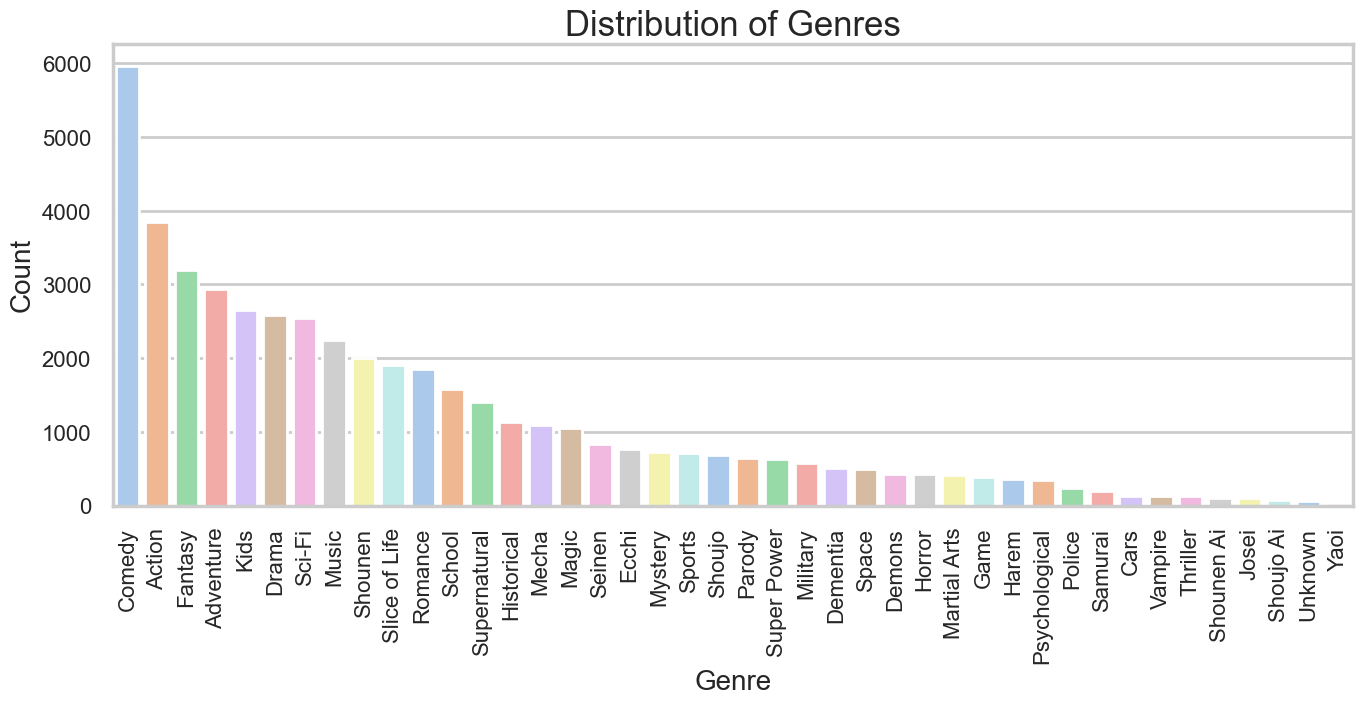

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style and context
sns.set_style('whitegrid')
sns.set_context('poster')  # Increase the base size of all fonts

# Prepare the data
genre_counts = pd.Series(all_genres).value_counts()

# Create the plot
plt.figure(figsize=(16, 6))

colors = sns.color_palette('pastel')[0:len(genre_counts)]
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)

plt.title('Distribution of Genres', fontsize=25)  # Increase fontsize for title
plt.xlabel('Genre', fontsize=20)  # Increase fontsize for x label
plt.ylabel('Count', fontsize=20)  # Increase fontsize for y label
plt.xticks(rotation=90, fontsize=16)  # Increase fontsize for x ticks
plt.yticks(fontsize=16)  # Increase fontsize for y ticks

# Show and save the plot
plt.savefig('genre_distribution.png', dpi=1000, bbox_inches='tight')
plt.show()

### Downsampling semantically similar texts
Since we are using semantic similarity for our model, inputting texts that are semantically similar is redundant.

In [65]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Our model that encodes semantically similar texts to be near each other
downsample_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

def filter_semantically_similar_texts(texts, similarity_threshold=0.8):
    # Generate embeddings for all texts. These embeddings are representations of 
    # the texts in a high dimensional space, created in such a way that semantically 
    # similar texts are close to each other in this space.
    embeddings = downsample_model.encode(texts)

    # Calculate the cosine similarity between all pairs of text embeddings. The 
    # result is a matrix where the cell at the intersection of row i and column j
    # represents the cosine similarity between the embeddings of texts[i] and texts[j].
    similarity_matrix = cosine_similarity(embeddings)
    
    # Set the diagonal elements of the similarity matrix to 0, because they represent
    # the similarity of each text with itself, which is always 1.
    np.fill_diagonal(similarity_matrix, 0)

    # Initialize an empty list to store the texts that are not too similar to any 
    # other text.
    filtered_texts = []
    
    # Initialize a set to store the indices of the texts that are too similar to
    # another text.
    excluded_indices = set()

    # For each text...
    for i, text in enumerate(texts):
        # If the current text is not too similar to any other text...
        if i not in excluded_indices:
            # Add it to the list of non-similar texts
            filtered_texts.append(text)
            
            # Find the indices of the texts that are too similar to the current text
            similar_texts_indices = np.where(similarity_matrix[i] > similarity_threshold)[0]
            
            # Exclude these texts from further consideration
            excluded_indices.update(similar_texts_indices)

    return filtered_texts

In [66]:
unique_labels = sorted(list(set(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].apply(lambda x: x.split(', '))))))

In [67]:
print(len(unique_labels), unique_labels)

42 ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi']


In [68]:
id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}

In [79]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL = 'distilbert-base-uncased' 

model = AutoModelForSequenceClassification.from_pretrained(
        MODEL,
        problem_type="multi_label_classification", # can place a same animae into multiple genres
        num_labels=len(unique_labels),
        id2label = id2label,
        label2id = label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
import numpy as np
import torch

tokenizer = AutoTokenizer.from_pretrained(MODEL)

def preprocess_data(examples, text_col):
    one_hot_encoded_matrix = []
    text = examples[text_col]
    genres = examples["Genres"]
    for genre in genres:
        g = genre.split(', ')
        one_hot_encoded_row = [1 if label in g else 0 for label in unique_labels]
        one_hot_encoded_matrix.append(one_hot_encoded_row)

    # Convert the one_hot_encoded_matrix to a LongTensor
    one_hot_encoded_matrix = [torch.tensor(o, dtype=torch.float32) for o in one_hot_encoded_matrix]

    # Encode the text
    encoding = tokenizer(text, truncation=True, max_length=256)
    
    # Add labels
    encoding["labels"] = one_hot_encoded_matrix

    return encoding

In [71]:
from datasets import Dataset

anime_with_synopsis_dataset = Dataset.from_pandas(pre_merged_anime[['synopsis', 'Genres', 'generated_description']])
anime_with_synopsis_dataset = anime_with_synopsis_dataset.train_test_split(test_size=0.2, seed=42)

In [72]:
anime_with_synopsis_dataset

DatasetDict({
    train: Dataset({
        features: ['synopsis', 'Genres', 'generated_description'],
        num_rows: 12964
    })
    test: Dataset({
        features: ['synopsis', 'Genres', 'generated_description'],
        num_rows: 3242
    })
})

In [73]:
from tqdm.auto import tqdm
DOWNSAMPLE_TRAIN = True

def downsample_dataset(dataset, text_col, similarity_threshold=0.95):

    filtered_texts = filter_semantically_similar_texts(dataset[text_col], similarity_threshold)
    return [d for d in dataset if d[text_col] in filtered_texts]

if DOWNSAMPLE_TRAIN:
    anime_with_synopsis_dataset['train'] = Dataset.from_pandas(pd.DataFrame(
        downsample_dataset(anime_with_synopsis_dataset['train'], text_col='generated_description')
    ))

In [74]:
description_encoded_dataset = anime_with_synopsis_dataset.map(
    lambda x: preprocess_data(x, 'generated_description'),
    batched=True, batch_size=128, remove_columns=['synopsis', 'Genres', 'generated_description']
)

description_encoded_dataset

Map:   0%|          | 0/12828 [00:00<?, ? examples/s]

Map:   0%|          | 0/3242 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12828
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3242
    })
})

In [75]:
# description_encoded_dataset['train'][0]

In [76]:
# import the necessary libraries
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, jaccard_score
from transformers import EvalPrediction

In [77]:
# Define a function to compute multilabel metrics
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Initialize the sigmoid function which we'll use to transform our raw prediction values
    sigmoid = torch.nn.Sigmoid()
    
    # Apply sigmoid function to our predictions
    probs = sigmoid(torch.Tensor(predictions))
    
    # Create a binary prediction array based on our threshold
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # Use actual labels as y_true
    y_true = labels
    
    # Compute F1 score, ROC AUC score, Accuracy, and Jaccard score
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='micro')
    
    # Package the scores into a dictionary and return it
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'jaccard': jaccard}
    return metrics

# Define a function to compute metrics for predictions
def compute_metrics(p: EvalPrediction):
    # Extract the prediction values from the EvalPrediction object
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    
    # Compute the multi-label metrics for the predictions and actual labels
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    
    # Return the results
    return result

In [84]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
 

args = TrainingArguments(
    f"genre-prediction",
    eval_strategy = "epoch",  # used to be evaluation_strategy for < 4.46 version of Transformer
    save_strategy = "epoch",
    per_device_train_batch_size = 16,
    gradient_accumulation_steps = 4,  # effective batch size of 64
    per_device_eval_batch_size = 64,
    num_train_epochs = 2,  # I tried 10 and it took number of hours to complete the training
    logging_steps = 50,
    load_best_model_at_end=True,
    metric_for_best_model="jaccard",
)

trainer = Trainer(
    model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    processing_class = tokenizer,  # it used to be tokenizer for version < 5.0.0
    data_collator = data_collator,
    compute_metrics=compute_metrics
)

trainer.evaluate()

{'eval_loss': 0.5878058671951294,
 'eval_model_preparation_time': 0.0052,
 'eval_f1': 0.03524419190102856,
 'eval_roc_auc': 0.4969498314195003,
 'eval_accuracy': 0.00030845157310302283,
 'eval_jaccard': 0.01793820471518524,
 'eval_runtime': 845.8931,
 'eval_samples_per_second': 3.833,
 'eval_steps_per_second': 0.06}

In [85]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Roc Auc,Accuracy,Jaccard
1,0.177400,0.176142,0.005200,0.294974,0.589606,0.064775,0.173002


TrainOutput(global_step=400, training_loss=0.21720295906066894, metrics={'train_runtime': 99233.6979, 'train_samples_per_second': 0.259, 'train_steps_per_second': 0.004, 'total_flos': 1661964704647632.0, 'train_loss': 0.21720295906066894, 'epoch': 1.9925187032418954})

### Model with Frozen Weights

In [86]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    problem_type = 'multi_label_classification',
    num_labels = len(unique_labels),
    id2label = id2label,
    label2id = label2id
)

# Freeze everything up until the final 3 encoder layers, it has 6 attention layers
for name, param in model.named_parameters():
    if 'distilbert.transformer.layer.4' in name: # update only 4, 5 and 6
        break
    param.requires_grad = False


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
# same set up as earlier with model passed as frozen weights
args = TrainingArguments(
    f"genre-prediction",
    eval_strategy = "epoch",  # used to be evaluation_strategy for < 4.46 version of Transformer
    save_strategy = "epoch",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,  # effective batch size of 64
    per_device_eval_batch_size=64,
    num_train_epochs= 2,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="jaccard",
)

trainer_frozen = Trainer(
    model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    processing_class = tokenizer,  # it used to be tokenizer for version < 5.0.0
    data_collator = data_collator,
    compute_metrics=compute_metrics
)

trainer_frozen.evaluate()

{'eval_loss': 0.6904141902923584,
 'eval_model_preparation_time': 0.0,
 'eval_f1': 0.14315960683688778,
 'eval_roc_auc': 0.5400049510181465,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.07709849880689884,
 'eval_runtime': 6494.6677,
 'eval_samples_per_second': 0.499,
 'eval_steps_per_second': 0.008}

In [88]:
trainer_frozen.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Roc Auc,Accuracy,Jaccard
1,0.184000,0.181362,0.000000,0.254701,0.574836,0.056755,0.145935


TrainOutput(global_step=400, training_loss=0.22791676759719848, metrics={'train_runtime': 25651.9788, 'train_samples_per_second': 1.0, 'train_steps_per_second': 0.016, 'total_flos': 1661964704647632.0, 'train_loss': 0.22791676759719848, 'epoch': 1.9925187032418954})

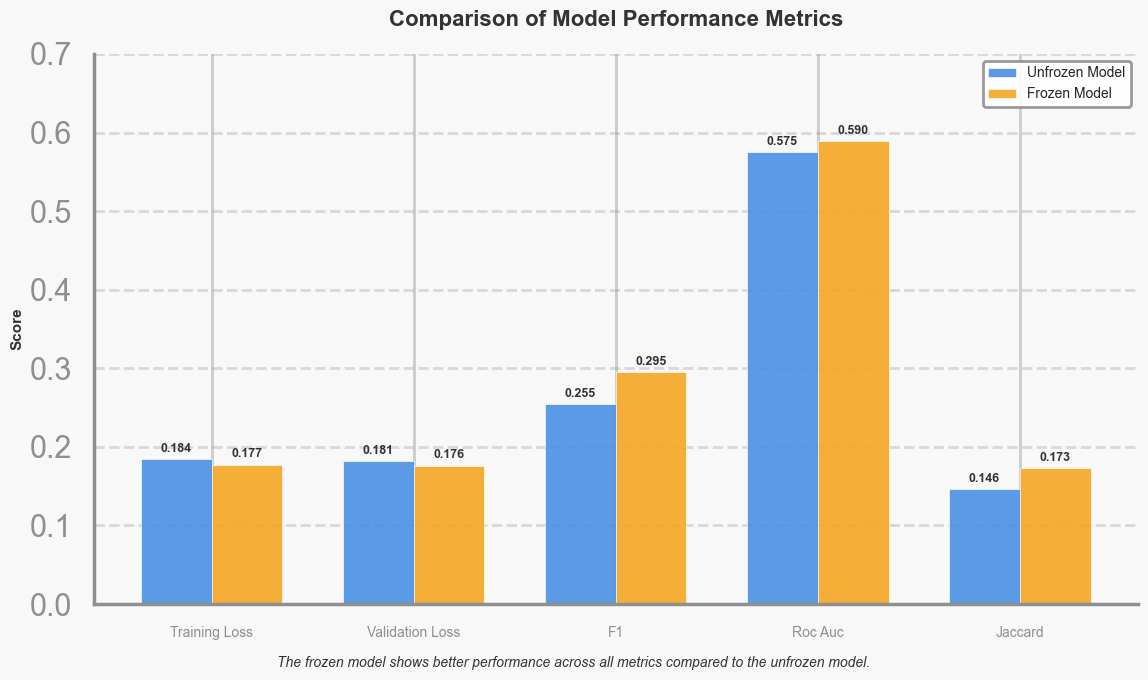

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from the tables
metrics_frozen = {
    'training_loss': 0.177400,
    'validation_loss': 0.176142,
    'f1': 0.294974,
    'roc_auc': 0.589606,
    'accuracy': 0.064775,
    'jaccard': 0.173002
}

metrics_unfrozen = {
    'training_loss': 0.184000,
    'validation_loss': 0.181362,
    'f1': 0.254701,
    'roc_auc': 0.574836,
    'accuracy': 0.056755,
    'jaccard': 0.145935
}

# Metrics to plot
metrics_to_plot = ['training_loss', 'validation_loss', 'f1', 'roc_auc', 'jaccard']
x = np.arange(len(metrics_to_plot))
width = 0.35

# NYT-inspired color palette
nyt_blue = '#4A90E2'       # Main blue
nyt_dark_blue = '#2A5DB0'  # Darker blue
nyt_orange = '#F5A623'     # Complementary orange
nyt_red = '#D0021B'        # Accent red
nyt_gray = '#8F8F8F'       # Background/grid color

# Create figure with single subplot
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('#F8F8F8')  # Light background (off-white)
ax.set_facecolor('#F8F8F8')

# Create bars
unfrozen_bars = ax.bar(x - width/2, [metrics_unfrozen[m] for m in metrics_to_plot], 
                      width, label='Unfrozen Model', color=nyt_blue, alpha=0.9, 
                      edgecolor='white', linewidth=0.5)
frozen_bars = ax.bar(x + width/2, [metrics_frozen[m] for m in metrics_to_plot], 
                    width, label='Frozen Model', color=nyt_orange, alpha=0.9, 
                    edgecolor='white', linewidth=0.5)

# Add labels and title with NYT-inspired typography
ax.set_ylabel('Score', fontsize=11, fontweight='bold', color='#333333')
ax.set_title('Comparison of Model Performance Metrics', 
             fontsize=16, fontweight='bold', color='#333333',
             pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_plot], 
                  fontsize=10, color='#333333')

# Add legend with custom styling
legend = ax.legend(fontsize=10, frameon=True, 
                  facecolor='white', edgecolor=nyt_gray, 
                  loc='upper right')
legend.get_frame().set_alpha(0.9)

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9,
                    color='#333333', fontweight='bold')

add_labels(unfrozen_bars)
add_labels(frozen_bars)

# Set y-axis limits and format
ax.set_ylim(0, 0.7)
ax.grid(axis='y', linestyle='--', alpha=0.3, color=nyt_gray)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(nyt_gray)
ax.spines['bottom'].set_color(nyt_gray)
ax.tick_params(colors=nyt_gray)

# Add a subtitle/caption in NYT style
plt.figtext(0.5, 0.01, 
            "The frozen model shows better performance across all metrics compared to the unfrozen model.",
            ha='center', fontsize=10, fontstyle='italic', color='#333333')

# Set tight layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)

plt.show()

In [91]:
# save model - trainer model with unfrozen weights is better
trainer.save_model()

In [93]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Use from_pretrained instead of direct initialization
trained_model = AutoModelForSequenceClassification.from_pretrained(
    "genre-prediction",  # Path to the saved model
    problem_type="multi_label_classification"
).eval()

classifier = pipeline(
    "text-classification", model=trained_model, tokenizer=tokenizer, return_all_scores=True
)

Device set to use cpu
c:\Users\anita\Desktop\clustering_ny_city_planning\.venv\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [95]:
import random
random_animes = pre_merged_anime.sample(3)
texts = list(random_animes['generated_description'])
labels = list(random_animes['Genres'])

In [97]:
prediction = classifier(texts)
THRESHOLD = 0.5

prediction = [[label for label in p if label['score'] > THRESHOLD] for p in prediction]

for _text, scores, label in zip(texts, prediction, labels):
    print(_text)
    print('*' * 50)
    for _score in sorted(scores, key=lambda x: x['score'], reverse=True):
        # Fix the quote issue by using different quote styles
        print(f"{_score['label']}: {_score['score'] * 100:.2f}")
    print('actual labels: ', label)
    print('*' * 50)

One Punch Man: Road to Hero is a OVA anime.
Synopsis:Before Saitama became the man he is today, he trained and fought endlessly to become a hero. While every scuffle leaves his tracksuit uniform in tatters, he always has it mended for free thanks to his local tailor. One day, however, the tailor informs him that he must close up shop due to pressure from a local gang. Saitama decides to help him outand gains something irreplaceable in the process.
It was produced by Unknown and it is from Madhouse Studio.
It's source is Web manga.
It premiered in Unknown.
**************************************************
Action: 60.17
actual labels:  Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural
**************************************************
Yowamushi Pedal: Re:RIDE is a Movie anime.
Synopsis:lling of the first season, taking place at Toudou's family inn where he, Makishima, and Onoda reflect on the events.
It was produced by TOHO animation and it is from TMS Entertainment Studio.
It's

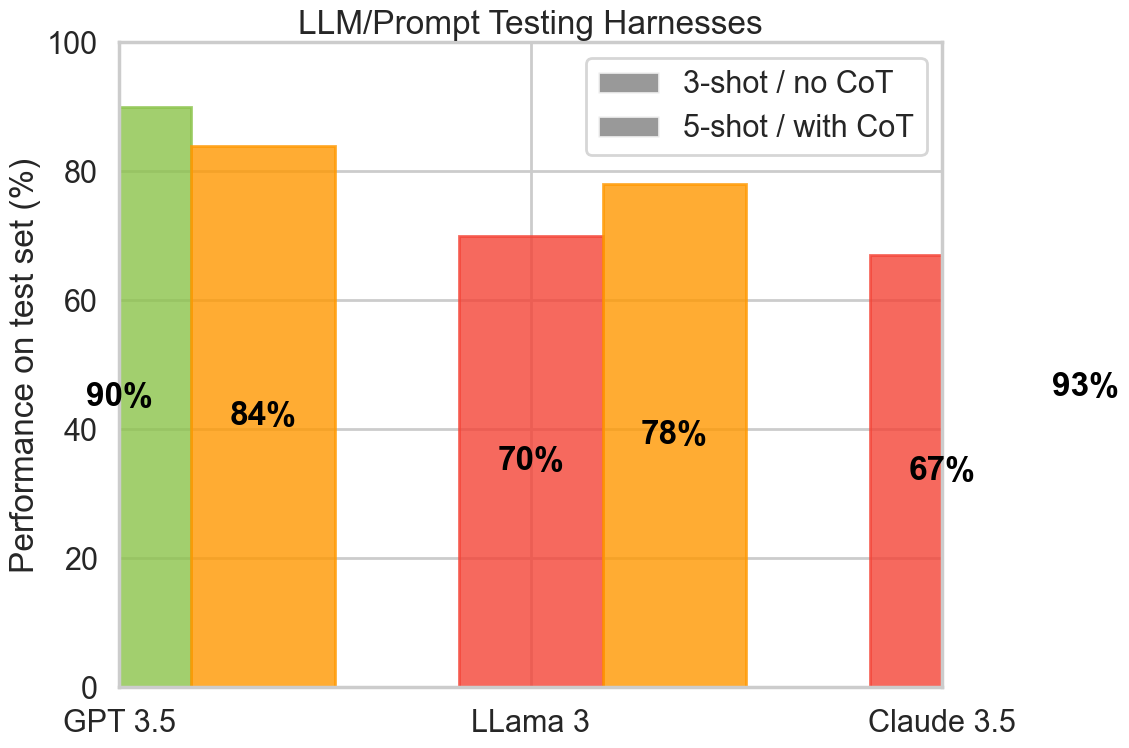

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Create dataframe with model performance data
models = ['GPT 3.5', 'LLama 3', 'Claude 3.5']
shot_types = ['3-shot / no CoT', '5-shot / with CoT']

# Performance data based on the image
performance_data = {
    ('GPT 3.5', '3-shot / no CoT'): 90,
    ('LLama 3', '3-shot / no CoT'): 70,
    ('Claude 3.5', '3-shot / no CoT'): 67,
    ('GPT 3.5', '5-shot / with CoT'): 84,
    ('LLama 3', '5-shot / with CoT'): 78,
    ('Claude 3.5', '5-shot / with CoT'): 93,
}

# Prepare data for visualization
data = []
for model in models:
    for shot in shot_types:
        data.append({
            'Model': model,
            'Prompt Type': shot,
            'Performance': performance_data.get((model, shot), 0)
        })

df = pd.DataFrame(data)

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Create a grid to place each model-shot combination
positions = np.arange(len(models))
width = 0.35

# Performance colors based on value ranges
def get_color(val):
    if val >= 90:
        return '#8BC34A'  # Green
    elif val >= 75:
        return '#FF9800'  # Orange
    else:
        return '#F44336'  # Red

# Plot the bars for each shot type
for i, shot in enumerate(shot_types):
    subset = df[df['Prompt Type'] == shot]
    for j, (_, row) in enumerate(subset.iterrows()):
        color = get_color(row['Performance'])
        rect = ax.add_patch(plt.Rectangle(
            (positions[j] - width/2 + i*width, 0), 
            width, 
            row['Performance'], 
            color=color,
            alpha=0.8
        ))
        # Add text label in the center of each bar
        ax.text(positions[j] - width/2 + i*width + width/2, 
                row['Performance']/2, 
                f"{row['Performance']}%", 
                ha='center', 
                va='center', 
                color='black',
                weight='bold')

# Customizations
ax.set_ylim(0, 100)
ax.set_ylabel('Performance on test set (%)')
ax.set_title('LLM/Prompt Testing Harnesses')
ax.set_xticks(positions)
ax.set_xticklabels(models)

# Add a legend for shot types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=0.8, label='3-shot / no CoT'),
    Patch(facecolor='gray', alpha=0.8, label='5-shot / with CoT')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()